### Aim/Object: 
To measure the geometry parameters from a sparse projection data set of a stack of beads.

In cone-beam tomography, the projections are distorted by the perspective the divergent
beam is producing. This means that geometry is essential to the successful
reconstruction of tomography. The center of rotation and the pixel size (this is only
needed to scale the attenuation coefficients) which is the only information required for
parallel beam reconstruction. For cone-beam reconstruction, you further need to know the
distances from the source to the sample (object), the distance from the source to the detector
(SDD). These parameters define the magnification of the configuration and would in
principle be sufficient for the reconstruction. The beam usually doesn’t hit the detector
perpendicularly, therefore we also need to know the position of the piercing point on the
detector px and py.


### Parameters needed for a clean reconstruction: 

1. COR - Center of Rotation 
2. CTilt - Tilt of the Rotation Axis
3. SOD - Source Object Distance
4. SDD - Source Detector Distance
5. PP - Piercing Point 

### Importing libraries and the py file containing all the functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as im
import amglib.readers as io
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import cbct
import importlib


C:\Users\kaestner\git\CBCTCalibration\amglib\imageutils.py:8: FutureWarning: Importing from skimage.morphology.greyreconstruct is deprecated. Please import from skimage.morphology instead.
  import skimage.morphology.greyreconstruct as rec


### Loading the py file containing all the functions

In [2]:
importlib.reload(cbct)

<module 'cbct' from 'C:\\Users\\kaestner\\git\\CBCTCalibration\\cbct.py'>

### Importing the dark current, open beam and projection images

In [3]:
datapath = 'C:/Users/Asus/OneDrive - National University of Singapore/Study/ETH Zurich/Quantitative Big Imaging/P20221368/02_rawdata/03_Beads_2.37x/'

In [4]:
dc=io.read_images(datapath+"dc_{:05}.fits",first=1,last=10,averageStack=True,average='mean');
ob=io.read_images(datapath+"ob_{:05}.fits",first=1,last=10,averageStack=True,average='mean');
cal=io.read_images(datapath+"beads_{:05}.fits",first=1,last=360,stride=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Visualizing a set of dark current, open beam and projection images

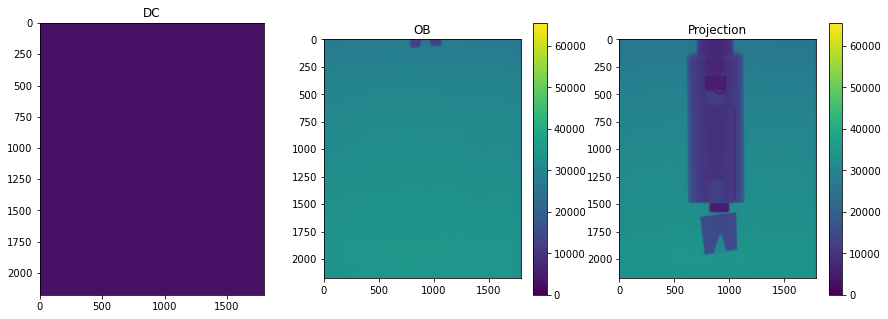

In [5]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
a1=ax[1].imshow(ob)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')
a2=ax[2].imshow(cal[1,:,:]) #,vmin=0.0,vmax=10000)
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');

### Normalization:    
The first step is to normalize the projections of the images using the dark current and the open beam images. Image texture is one of the very important factors for a good reconstruction. This is often distorted by the noise during scanning and other artifacts that may be present. Thus, we need to normalize the images. This is followed by flipping the image for an upright orientation. 


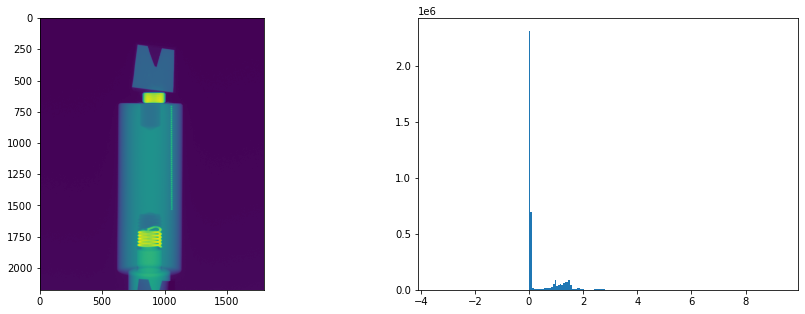

In [6]:
lcal=cbct.normalizeData(cal,ob,dc)
flipProjection = True
if flipProjection : 
    lcal = lcal[:,::-1,:]
    
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(lcal[1],vmin=0,vmax=3)
ax[1].hist(lcal[1].ravel(),bins=200);

### Cropping: 

The next step is to crop the image by converting the pixels of all unwanted elements into 0 such that they are not taken into consideration into the steps ahead for reconstruction. (This step is optional i.e depending on the magnification used, the extent of artifacts in the projection images varies depending on magnification used.)

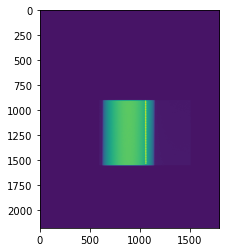

In [7]:
new_lcal=lcal.copy()
new_lcal[:,:,1500:]=0
new_lcal[:,:,:590]=0
new_lcal[:,1550:]=0
new_lcal[:,:900]=0


lcal=new_lcal
plt.imshow(new_lcal[1,:,:])

### Baseline Removal: 

This is followed by baseline removal such that only part left are the beads from the projection. This is done by setting an appropriate threshold to separate the rest of the image components from the beads and hence removing them by filtering them out. 

In [8]:
bcal=cbct.removeBaseline(lcal)

In [9]:
tcal=cbct.thresholdBBs(bcal,4)

### Watershed Segmentation -Visualization (Optional to run)
This is followed by erosion of the leftover beads to remove any excess noise close to the beads and then performing watershed fragmentation on them. 

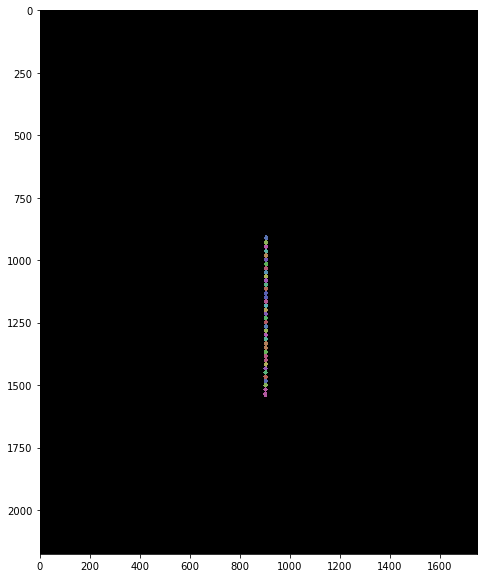

In [10]:
#optional- for visualization
cbct.watershed_segmentation_display(tcal, 10)

### Identifying the trajectory of the ellipses: 


The next step is to identify the beads from the image of the segmented beads in order to track their trajectories across the many images taken. 
Method for bead detection deployed: 
- The centers of the watershed segmented beads are identified using skimage regionprops. 
- The centres obtained in the regionprops table are then converted to a 2D coordinate system form for easier understanding. 

This is followed by writing a function buildbeads that tracks the path of a specific bead across all the projects and stores the centres in an array for further processing.   

Once the trajectory of the beads has been identified, the aim is to find ellipses that best fit the paths. In some cases, the bead trajectories obtained are not optimum and hence, need to be dropped from this process since the ellipse identified corresponding to them would not be an accurate representation of the bead patten and hence may create errors in the calculation of tomography parameters ahead. The reason for these distorted bead trajectory can be attributed to the interference from other beads or the noise in the area of the beads.  

The ellipses’ parameters i.e center coordinate, the lengths of the major and minor axis, and the tilt in the ellipse orientation are calculated by using the EllipseModel() package by python to which the input parameter is the array containing the centers of specific beads across all the projects. 




In [11]:
[e2,cog_allbeads]=cbct.identifyEllipses(tcal)

  0%|          | 0/36 [00:00<?, ?it/s]

ID Number =  0
center =  (879.7859743033638, 925.0430262453184)
angle of rotation =  -0.003518176436015967
axes major/minor =  172.91430297688748 4.438773513965229


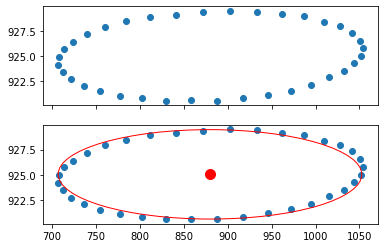

ID Number =  1
center =  (879.797882458884, 941.9415203756231)
angle of rotation =  -0.003569043115767334
axes major/minor =  170.7527233966543 4.982548052176848


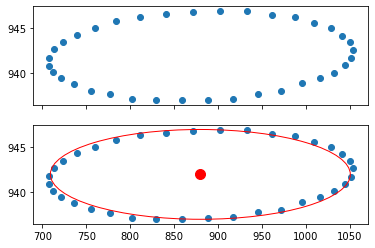

ID Number =  2
center =  (880.5845022995458, 958.9822051830232)
angle of rotation =  -0.003788239098442059
axes major/minor =  171.54561978788496 5.433996228223115


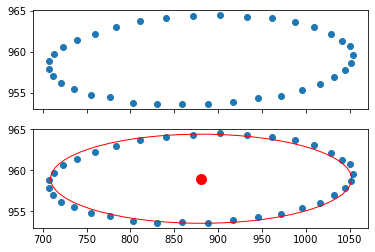

ID Number =  3
center =  (879.9618894867823, 975.7073417694195)
angle of rotation =  -0.0036835179048682054
axes major/minor =  171.9587058042976 5.881094893514607


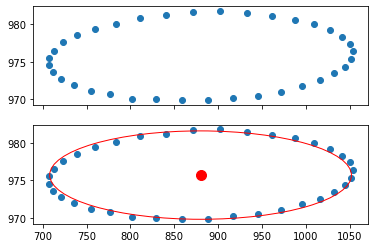

ID Number =  4
center =  (879.8515048288889, 992.5468526988177)
angle of rotation =  -0.0035387052428728083
axes major/minor =  173.17887832230198 6.303645122407686


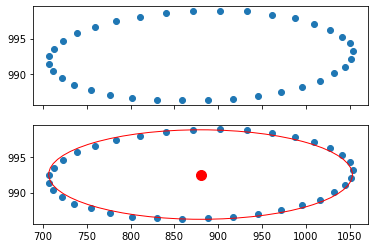

ID Number =  5
center =  (880.4448748638351, 1009.3937397280075)
angle of rotation =  -0.00355667108570409
axes major/minor =  173.17510165149986 6.7507378712087


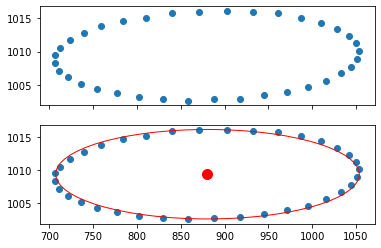

ID Number =  6
center =  (879.4197926662657, 1026.2225728137603)
angle of rotation =  -0.003975136327164941
axes major/minor =  173.37839249237302 7.20418523485701


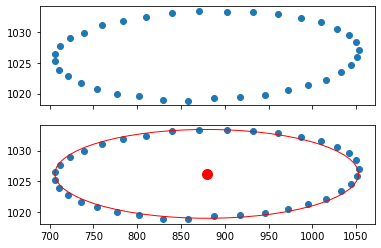

ID Number =  7
center =  (880.0408286500854, 1041.6013427747282)
angle of rotation =  -0.003824609026150643
axes major/minor =  174.41789858001817 7.587921192950973


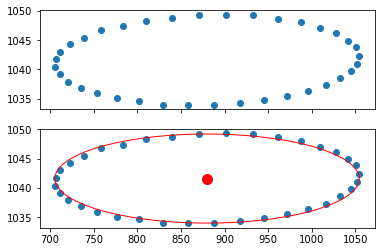

ID Number =  8
center =  (879.0912289912197, 1057.160224804918)
angle of rotation =  -0.0034011311280102152
axes major/minor =  173.41949468063933 8.079278894924835


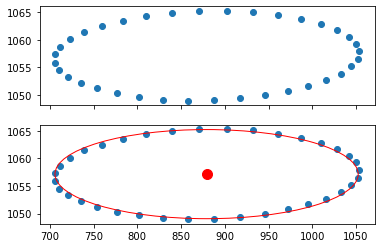

ID Number =  9
center =  (879.3170237090825, 1073.3994555444115)
angle of rotation =  -0.003296800062455141
axes major/minor =  173.12952919985023 8.544038623818851


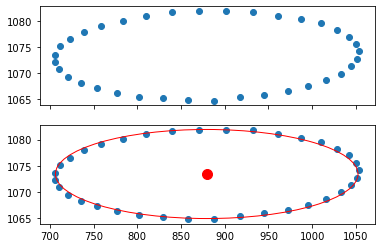

ID Number =  10
center =  (879.699981434423, 1089.9038011630194)
angle of rotation =  -0.0032571882989623625
axes major/minor =  174.1982951161195 8.94950398679389


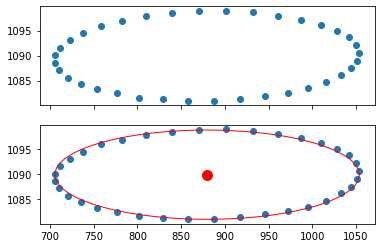

ID Number =  11
center =  (879.2263312391165, 1106.4076060346135)
angle of rotation =  -0.003225815961694121
axes major/minor =  174.68826277931532 9.396574731923321


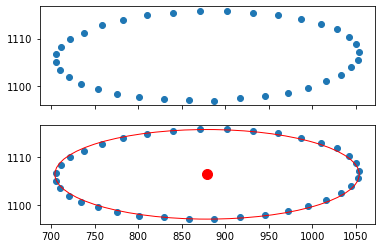

ID Number =  12
center =  (879.0843401461852, 1122.562928296808)
angle of rotation =  -0.0031515614859377464
axes major/minor =  174.71763238418748 9.814753432527088


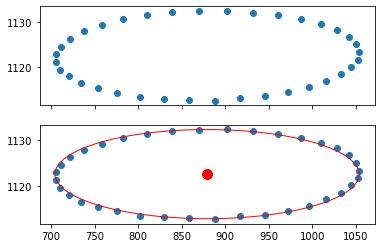

ID Number =  13
center =  (879.3157623494328, 1138.8600615822324)
angle of rotation =  -0.0035045291327561023
axes major/minor =  174.6635173419061 10.275361490514696


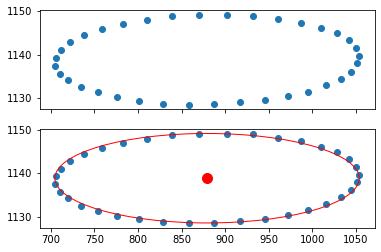

ID Number =  14
center =  (879.1643574731473, 1155.3247762638398)
angle of rotation =  -0.0035938107885145065
axes major/minor =  174.93935804714891 10.749048081031086


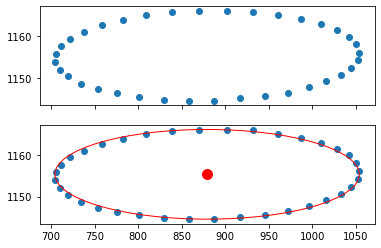

ID Number =  15
center =  (879.0635766807698, 1171.9606265637774)
angle of rotation =  -0.003560792755874509
axes major/minor =  174.7826872199505 11.20066501652156


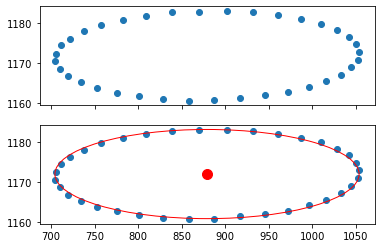

ID Number =  16
center =  (878.1786743822768, 1188.3477128526663)
angle of rotation =  -0.0034542084775918847
axes major/minor =  174.9262418991612 11.606183607817645


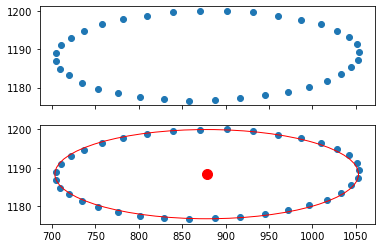

ID Number =  17
center =  (878.9470322662497, 1203.5132364422027)
angle of rotation =  -0.0035962891806100073
axes major/minor =  174.92589744461594 12.06220529818709


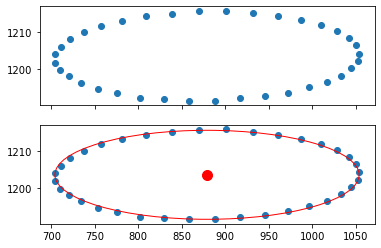

ID Number =  18
center =  (879.1243741215737, 1219.1701147589906)
angle of rotation =  -0.003689048600589362
axes major/minor =  175.0306004060809 12.554672594836248


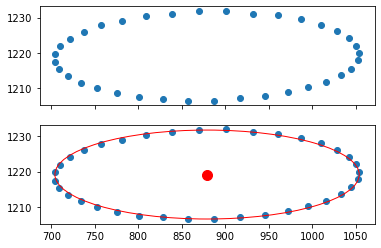

ID Number =  19
center =  (878.8924954534278, 1235.5899544658087)
angle of rotation =  -0.0034265603945486944
axes major/minor =  175.44707682515195 12.964590475974479


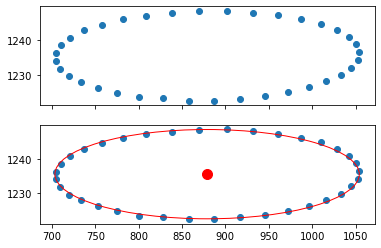

ID Number =  20
center =  (878.7834174209903, 1252.203958551976)
angle of rotation =  -0.0037792223276034796
axes major/minor =  175.6938222846682 13.386094627036975


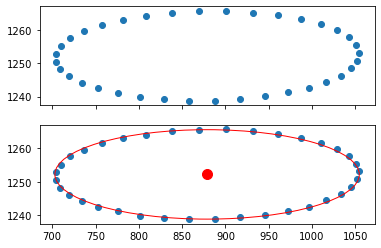

ID Number =  21
center =  (878.8956016080567, 1268.7759239488605)
angle of rotation =  -0.003584096285939745
axes major/minor =  175.7320534515512 13.862608094953199


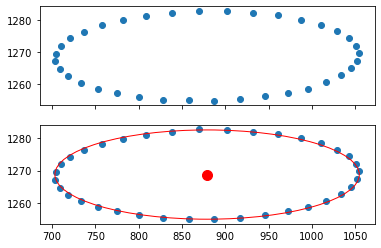

ID Number =  22
center =  (878.7608404380255, 1285.1561034786253)
angle of rotation =  -0.00364133407395828
axes major/minor =  175.35059293301902 14.374600048591699


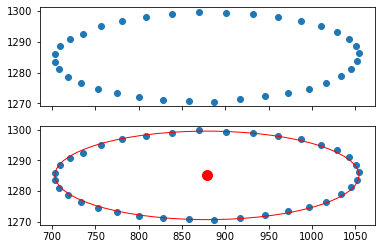

ID Number =  23
center =  (878.7526453850045, 1301.6777837445845)
angle of rotation =  -0.003632170867054807
axes major/minor =  175.5778948012569 14.854141163702439


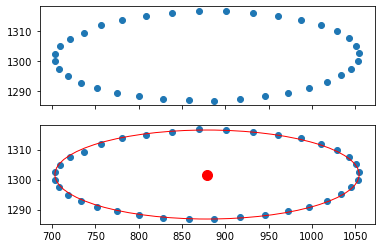

ID Number =  24
center =  (878.5652524274673, 1318.410201912753)
angle of rotation =  -0.003727631276072281
axes major/minor =  175.86299299027473 15.308726335485742


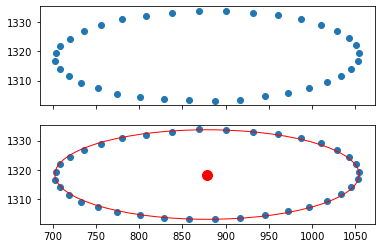

ID Number =  25
center =  (878.6252829478888, 1334.8232201230776)
angle of rotation =  -0.0035728566762108704
axes major/minor =  176.13404406589717 15.775859755161923


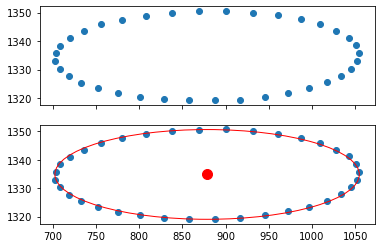

ID Number =  26
center =  (878.347181207559, 1351.2260059033697)
angle of rotation =  -0.003467224578244283
axes major/minor =  176.22423858911785 16.199737657444732


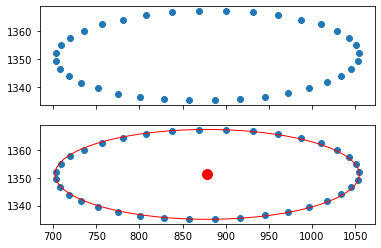

ID Number =  27
center =  (878.3971708123723, 1367.5990787674452)
angle of rotation =  -0.0035260598002109546
axes major/minor =  176.38032772058267 16.69274815590424


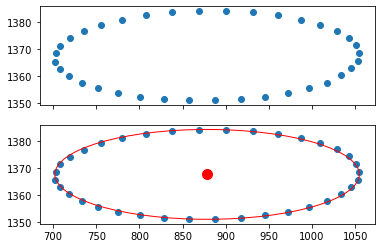

ID Number =  28
center =  (878.4748608948844, 1383.9507719084643)
angle of rotation =  -0.0035079036956346954
axes major/minor =  176.72227517142326 17.173634917934425


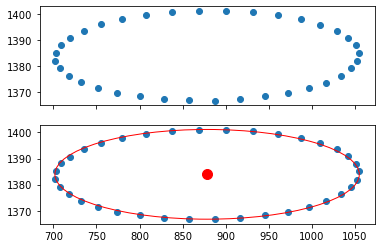

ID Number =  29
center =  (878.3966156209901, 1400.2967424605965)
angle of rotation =  -0.0036599819324674154
axes major/minor =  176.8475538484536 17.610537453112556


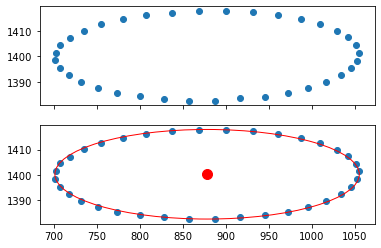

ID Number =  30
center =  (878.3521085623362, 1415.8286599626229)
angle of rotation =  -0.003464633958412122
axes major/minor =  176.44607406869883 17.962515963163206


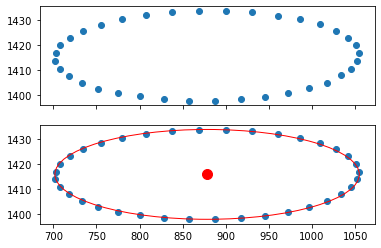

ID Number =  31
center =  (878.0317007923072, 1431.4415520238545)
angle of rotation =  -0.0032694837600619024
axes major/minor =  176.90604017308308 18.46395938094341


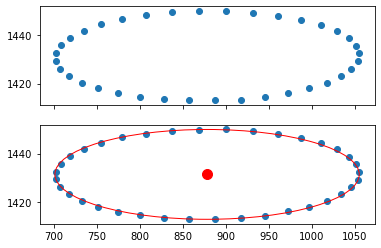

ID Number =  32
center =  (878.0356211862645, 1448.1278372037107)
angle of rotation =  -0.0035059274947872865
axes major/minor =  176.89748255860601 18.970563461186117


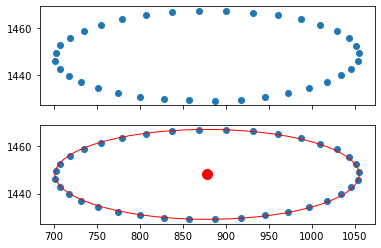

ID Number =  33
center =  (877.9844339577364, 1464.733157551536)
angle of rotation =  -0.003494910100290904
axes major/minor =  177.20641965252446 19.440549274678332


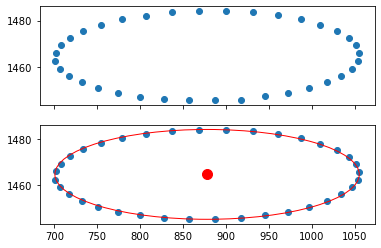

ID Number =  34
center =  (878.0315079262746, 1481.3359710396064)
angle of rotation =  -0.0035855015012376578
axes major/minor =  177.1966528519139 19.92998049868703


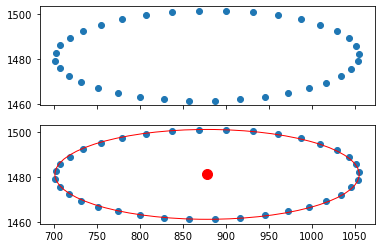

ID Number =  35
center =  (878.0423315111689, 1497.9972986600237)
angle of rotation =  -0.003679077400648922
axes major/minor =  177.24487732653245 20.361091895637973


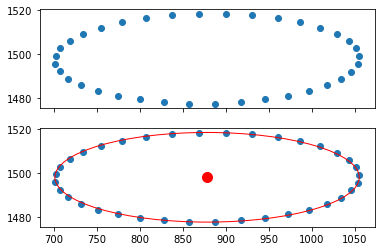

In [12]:
#optional to execute - it is for visualization of the ellipses plotted by the previous function 
cbct.show_ellipses(e2, cog_allbeads)

In [13]:
#deleting first few ellipses and beads due to distortion that occurs in their trajectory that may lead to erroneous calculations. 
del e2[0:3]
del cog_allbeads[0:3]

#### Structure of Array "e2":
#### [x-coordinate of the centre, 
#### y_coordinate of the centre, 
#### Length of the Major Axis, 
#### Length of the Minor Axis, 
#### Angular tilt of the ellipse]


### Estimating the Center of Rotation and its Tilt

The centre of rotation and tilt is calculated by using the best fit line for the center of all the trajectories of the beads through the multiple projections. 

A polynomial of degree 1 is approximated to fit the trend of the centres. The 2 main parameters obtained from the calculation give the tilt and the center of rotation axis coordinate. 

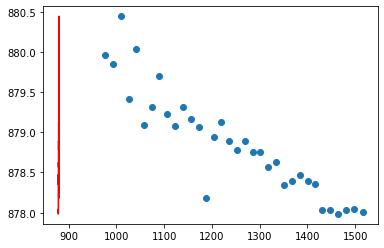

The parameters of the COR obtained are as follows: 883.4430072005335
The tilt of the center of rotation is in degrees:  -0.21083514038485618


{'COR': 883.4430072005335, 'Ctilt': -0.21083514038485618}

In [33]:
cbct.estimate_cor(e2)

### Estimating the Magnification

The magnification is calculated by using one of the projection images. The mean distance between the centres of the beads is calculated and then multiplied by the pixel pitch i.e. 0.139mm to obtain the magnification. 

[2.35370438 2.35727988 2.35764333]


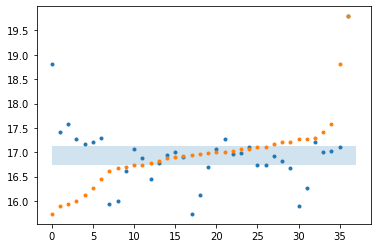

In [15]:
mag= cbct.estimate_magnification(tcal, 11)

### Estimating the Piercing Point: 

Piercing Point is the minima of all the elliptical trajectories. The minor axis for the ellipse at the piercing point is 0. Thus, the strategy applied is to plot a graph of minor axis length versus the height of the ellipse i.e the y-coordinate of the centre of the ellipse. The best linear fit line on being extrapolated gives the y-coordinate of the piercing point. Further using the best linear fit line for the centres of the ellipses, we can obtain the x-coordinate of the piercing point. 

Piercing Point is at:  (880.5898541901655, 775.3588308458217)


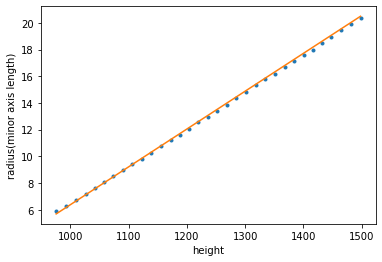

In [32]:
[h_piercing, v_piercing]= cbct.estimate_piercingpoint(e2)

Plotting the various ellipses together in a single graph.

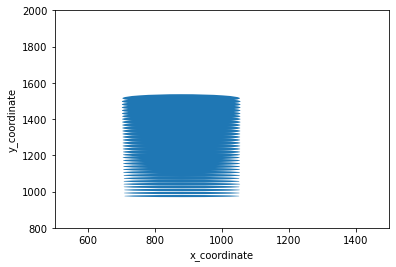

In [17]:
cbct.plot_allellipses(e2)

### Estimating the Source Object Distance (SOD) and the Source Detector Distance (SDD):

This is done by using two similar triangle geometries to calculate the various heights of the beads and hence the SOD and SDD. 
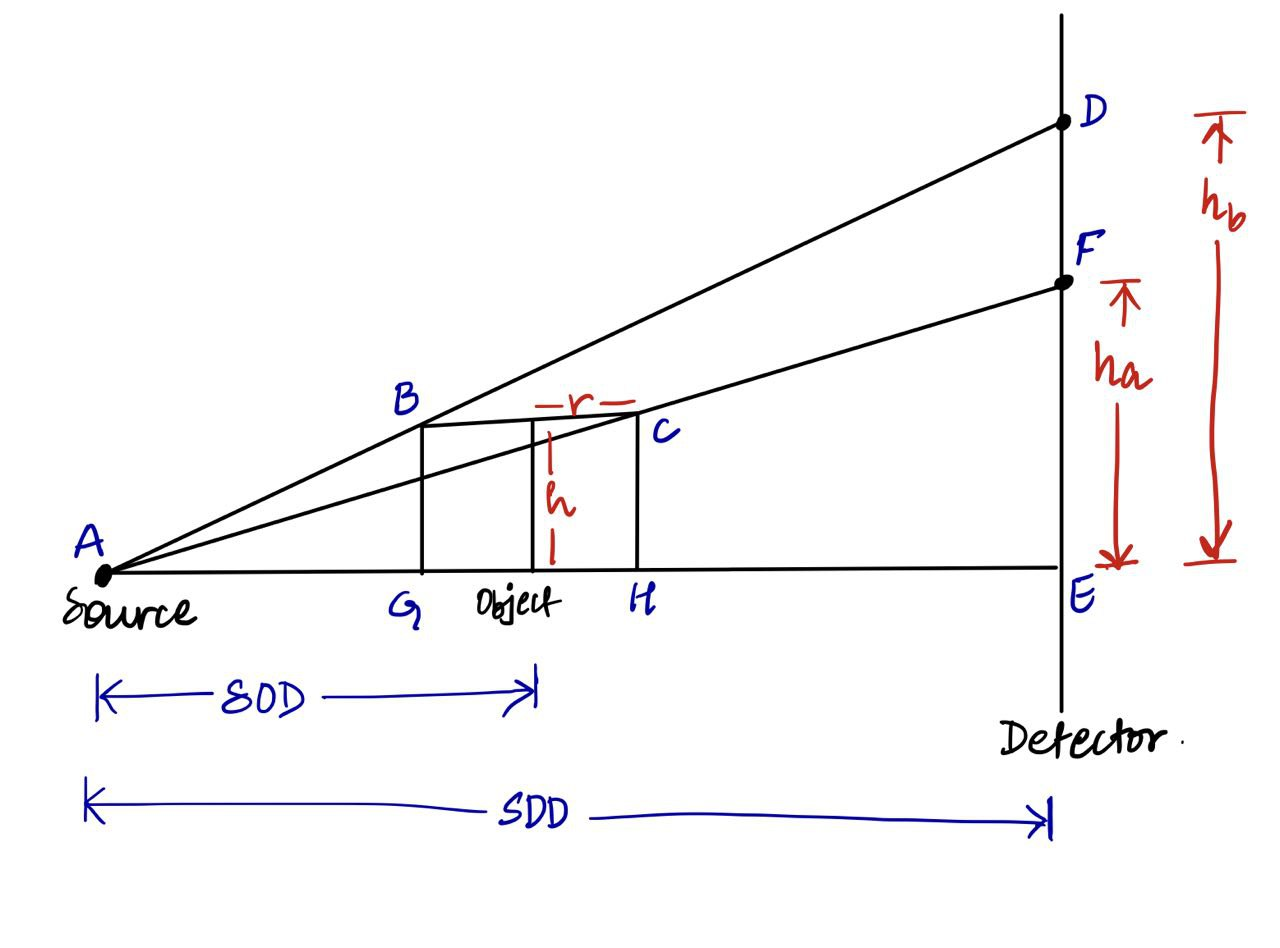 


4 triangles that can be identified from the above are: $\Delta ABG$, $\Delta ADE$, $\Delta ACH$, $\Delta AFE$

The similar triangles' pairs are: $\Delta ABG$ and $\Delta ADE$ , $\Delta ACH$ and $\Delta AFE$

By using similarity, we have the following equations: 

$$ \frac{AG}{AE} = \frac{BG}{DE} $$  and  $$ \frac{AH}{AE} = \frac{CH}{FE} $$ 

$$ \frac{SOD - r}{SDD} = \frac{h}{h_{b}} $$  and  $$ \frac{SOD + r}{SDD} = \frac{h}{h_{a}} $$ 

After extracting value of $ h $, we equate the two equations as follows: 

$$ h_{b}(SOD - r) = h_{a}(SOD + r) $$

$$ \frac{(SOD - r)}{(SOD + r)} = \frac{h_{a}}{h_{b}} $$

$$ SOD \cdot h_{b} - r \cdot h_{b} = SOD \cdot h_{a} + r \cdot h_{a}$$

$$ SOD \cdot (h_{b} - h_{a}) = r \cdot (h_{b} + h_{a}) $$

$$ SOD = \frac{(h_{b} + h_{a}) \cdot r}{(h_{b} - h_{a})} $$

Using magnification we find earlier we calculate the $ SDD $ using the following relation between $ SDD, SOD $ and $ magnification (mag) $ :

$$mag = \frac{SDD}{SOD}$$

$$ SDD = mag \cdot SOD $$

An additional factor of 1.08 is included in the calculation of SOD to account of the error in the final answer.

In [18]:
cbct.estimate_sod_sdd(tcal, e2, v_piercing,mag)

Mean SOD=  380.42174902294795
Mean SDD=  895.4003362288234
Magnification=  2.3537043781763662
Standard deviation in SOD=  5.760220671593038
Standard deviation in SDD=  13.55785661399054


{'sod': 380.42174902294795,
 'sdd': 895.4003362288234,
 'magnification': 2.3537043781763662,
 'sd_sod': 5.760220671593038,
 'sd_sdd': 13.55785661399054}

### Sample Reconstruction: 

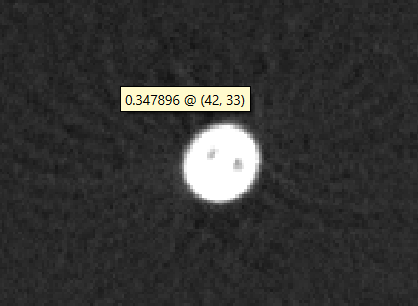

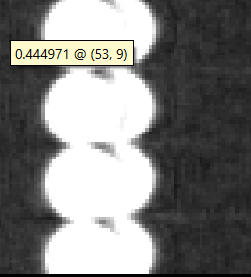

